# The Energy-Efficient Ghosts of Holiday Past

Welcome to the <i> Energy-Efficient Ghosts of Holiday Past </i> Challenge, an exploration into residential energy load profiles tailored for Scrooge's Holiday Party planning while uncovering innovative uses for the <b> RTDIP </b> platform. In this challenge, you will be given end-use load profiles for 201 unique buildings, including the Scrooge House, along with comprehensive metadata for these buildings. Your task is to identify the optimal continuous 4-hour window for Scrooge's Party, that minimizes the Party cost, and provide a predictive forecast of the Party cost.


### Supplied Materials:
 
*  Starter Notebook
*  200 `<building_id>.parquet` files containing timestamped end-use load profiles for 200 buildings
*  `<scrooge_bldg>.parquet` file containing timestamped end-use load profiles for the Scrooge House
*  `metadata.parquet` and `scrooge_metadata.parquet` files containing the metadata for 200 buildings, and the Scrooge House, respectively
*  `data_dictionary.tsv` file serving as a reference guide for building characteristics and load profiles available across the dwelling units;
*  `enumeration_dictionary.tsv` file outlining the available options for each building characteristic; the two `.tsv` dictionary files are designed to assist you in comprehending the meaning of various variables found in both time series and metadata. They offer descriptions for all load variables and metadata fields.
*  `equirements.txt` should contain all required packages

### Data:

Each of the above-metioned 201 timestamped `.parquet` files contains time series of a large number of end-use loads (energy consumption) for the corresponding building, starting from Jan 1, 2018 (`2018-01-01 00:15:00`) till the end of  Dec 21, 2018 (`2018-12-22 00:00:00`), with 15 minutes incremenets. All the times are in Eastern Standard Time (EST). All energy consumptions are in `kWh`. Energy consumptions for each timestamp (row) are the energy consumed during the 15 minutes ending at that timestamp. For example, for the row corresponding to `2018-12-20 17:15:00` all the energy load values at different columns are the energy consumed from `2018-12-20 17:00:00` till `2018-12-20 17:15:00`. Description of all the different loads and building characteristics in timestamped and metadata files could be found in the `data_dictionary.tsv` file.


Utilizing the challenge details outlined in the challenge description, such as, ToU tariffs and Party time constraints, your goal is to determine the most favorable continuous 4-hour period for Scrooge's Party along with the associated Party cost. Reiterating the ToU rates and Party time constraints for your reference:

* Scrooge's subscribed Time-of-Use (ToU) tariff for both weekdays and weekends is outlined as: From 6:00 pm to 10:00 pm, the rate is \\$0.35 per kWh. outside of this period, the rate stands at \\$0.20 per kWh.
* The Scrooge plan to schedule the four-hour Party any day between <b> December 22nd and the end of December</b>, <b> exclusively from 5:00 PM to midnight</b>.

Please also note that all submissions <b> must </b> utilize the RTDIP for at least one part of their solution.


### Data loading and exploration

Below are a few code snippets that show you how to load and explore the data.

Please remember to include any packages you use in a `requirements.txt` file and include it in the starter notebook folder.

In [1]:
# ONLY RUN THIS CELL ONCE 
!pip install -r requirements.txt

In [2]:
# Import the required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from utils import sample_submission_generator, scoring
import json
import requests
from scipy.interpolate import interp1d
import lightgbm as lgb

### Set global variables for reproducibility
For the sake of reproducibility, we define two variables, namely, DO_DOWNLOAD, and DO_TRAIN as follows:

* DO_DOWNLOAD: download weathre data with the help of RTDIP's authentication functionality when set to True. Load the data from file when set to False.
* DO_TRAIN: train the lightGBM models when set to True. Load trained lightGBM models when set to False.

For now, we set both variables to False so that the results produced by the notebook can be reproduced.

In [3]:
# In order to reproduce the results, set DO_DOWNLOAD and DO_TRAIN to False
DO_DOWNLOAD = False
DO_TRAIN = False

### Prepare historical weather data and observe historical load data
In this competition, we download the temperature data (and data of some other quantities) via RTDIP from https://weather.visualcrossing.com. As the daily quota is limited, we are currently able to download historical weather data ranging from 2018-11-26 to 2019-01-01 of the point of interest without exceeding the daily quota.

Note that we have the file <i>./weather_20181126_20190101.json </i> ready for reproducing the results when DO_DOWNLOAD is set to False.

After the weather data is loaded, we extract the temperature values from the json object and create the temperatures variable.

In [4]:
# Download the temperature data (and data of some other variables) via RTDIP
# We have the file './weather_20181126_20190101.json' ready for reproducing the results when DO_DOWNLOAD is set to False
if DO_DOWNLOAD:
    from rtdip_sdk.authentication import authenticate as auth
    # Replace with your actual values
    tenant_id = 'YOUR_TENANT_ID'
    client_id = 'YOUR_CLIENT_ID'
    client_secret = 'YOUR_CLIENT_SECRET'
    ClientSecretCredential = auth.ClientSecretAuth(tenant_id, client_id, client_secret).authenticate()
    access_token = 'YOUR_ACCESS_TOKEN' # You can obtain it using ClientSecretCredential.get_token("YOUR_RESOURCE_IDENTIFIER").token

    # Replace with your actual API key
    KEY = 'YOUR_API_KEY'
    
    START_DATE = '2018-11-26'
    END_DATE = '2019-01-01'
    url = f'https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/40%20Walpole%20Terrace%2C%20Canton%2C%20MA%2002021%2C%20USA/{START_DATE}/{END_DATE}?unitGroup=metric&include=hours&key={KEY}&contentType=json'
    
    payload={}
    params = {}
    headers = {
    'Authorization': 'Bearer {}'.format(access_token)
    }
    
    response = requests.request("GET", url, headers=headers, params=params, data=payload)

    data = json.loads(response.text)
    
    # file_name = 'weather_20181126_20190101.json'
    # with open(file_name, 'w') as file:
    #     json.dump(data, file, indent=4)
    # print(f"JSON data has been written to {file_name}")
    
else:
    file_path = './weather_20181126_20190101.json'
    with open(file_path, 'r', encoding='utf-8') as file:
        data = json.load(file)

In [5]:
# Extract temperature from the json object
days_list = range(0, 37) # There are a total of 37 days 
hours_list = range(0, 24) # A day has 24 hours
temperatures = []
datetimes = []
for day in days_list:
    for hour in hours_list:
        temperature = data['days'][day]['hours'][hour]['temp']
        datetime = data['days'][day]['hours'][hour]['datetime']
        temperatures.append(temperature)
        datetimes.append(datetime)
        
# For now, only the temperatures are needed
temperatures = np.array(temperatures)


Below, the timestamped load profile for the Scrooge house (`scrooge_bldg.parquet`) is loaded as a pandas dataframe and the first 5 rows are displayed. Then five specific load profiles of the house (listed in `columns_to_plot`) are plotted between the dates, `start_date` and `end_date`.


In [6]:
scrooge_loadprofile_path = os.getcwd()+'/data/scrooge_bldg.parquet'
df_scrooge = pd.read_parquet(scrooge_loadprofile_path, engine='pyarrow')

# Show the first 5 rows of the df_scrooge dataframe
df_scrooge.head(5)

,timestamp,out.electricity.ceiling_fan.energy_consumption,out.electricity.ceiling_fan.energy_consumption_intensity,out.electricity.clothes_dryer.energy_consumption,out.electricity.clothes_dryer.energy_consumption_intensity,out.electricity.clothes_washer.energy_consumption,out.electricity.clothes_washer.energy_consumption_intensity,out.electricity.cooling_fans_pumps.energy_consumption,out.electricity.cooling_fans_pumps.energy_consumption_intensity,out.electricity.cooling.energy_consumption,...,out.zone_mean_air_temp.crawlspace_unvented.c,out.zone_mean_air_temp.crawlspace_vented.c,out.zone_mean_air_temp.furnace_airloop_ret_air_zone.c,out.zone_mean_air_temp.garage.c,out.zone_mean_air_temp.living_space.c,out.zone_mean_air_temp.mini_split_heat_pump_airloop_ret_air_zone.c,out.total.lrmer_95decarbby2035_15_2025start.co2e_kg,out.total.lrmer_lowrecost_15_2025start.co2e_kg,out.total.lrmer_lowrecost_25_2025start.co2e_kg,out.total.lrmer_midcase_15_2025start.co2e_kg
bldg_id,,,,,,,,,,,,,,,,,,,,,
scrooge_bldg,2018-01-01 00:15:00,0.001429,7.645961e-07,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,6.718272,0.0,0.0,3.053342,20.000024,8.325252,0.402163,0.734065,0.617941,0.765338
scrooge_bldg,2018-01-01 00:30:00,0.001000,5.676424e-07,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,6.671675,0.0,0.0,3.254445,20.000028,8.323182,0.398644,0.727645,0.612536,0.758644
scrooge_bldg,2018-01-01 00:45:00,0.001000,5.676424e-07,0.000000,0.000000,0.005571,0.000003,0.0,0.0,0.0,...,6.655136,0.0,0.0,3.114294,20.000028,8.326921,0.402160,0.734061,0.617937,0.765333
scrooge_bldg,2018-01-01 01:00:00,0.001000,5.676424e-07,0.015286,0.000007,0.013857,0.000006,0.0,0.0,0.0,...,6.649696,0.0,0.0,2.951918,20.000029,8.332577,0.409133,0.746788,0.628651,0.778604
scrooge_bldg,2018-01-01 01:15:00,0.001000,5.676424e-07,0.066429,0.000031,0.000000,0.000000,0.0,0.0,0.0,...,6.649030,0.0,0.0,2.859543,18.614784,8.337339,0.220180,0.407767,0.343966,0.422330


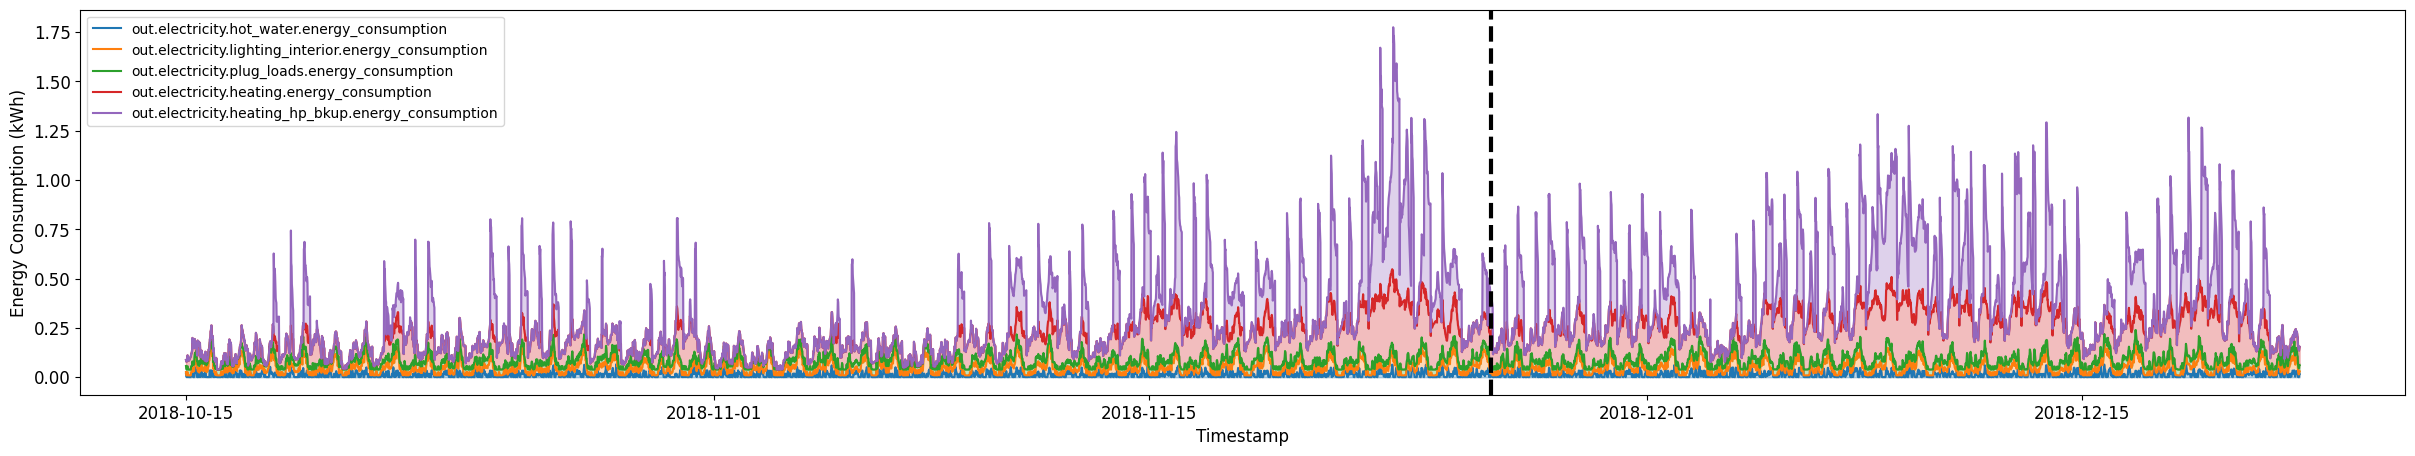

In [7]:
start_date = '2018-10-15 00:15:00'
end_date = '2018-12-22 00:00:00'

filtered_df = df_scrooge[(df_scrooge['timestamp'] >= start_date) & (df_scrooge['timestamp'] <= end_date)]
columns_to_plot =['out.electricity.heating_hp_bkup.energy_consumption',
                  'out.electricity.heating.energy_consumption',
                  'out.electricity.plug_loads.energy_consumption',
                  'out.electricity.lighting_interior.energy_consumption',
                  'out.electricity.hot_water.energy_consumption'
                  ]


# Set up the plot
fig, ax = plt.subplots(figsize=(30, 5))

zero_baseline = pd.Series(np.zeros(len(filtered_df)), index=filtered_df.index)

previous_line = None

for column in reversed(columns_to_plot):
    # Stacking requires the previous line's data
    if previous_line is not None:
        # Add the previous line's data to the current line
        filtered_df.loc[:, column] += filtered_df[previous_line]
        
    # Plot the stacked line
    line = ax.plot(filtered_df['timestamp'], filtered_df[column], label=column)

    # Fill between curves below the line with the same color
    if previous_line is not None:
        ax.fill_between(filtered_df['timestamp'], filtered_df[previous_line], filtered_df[column],
                        where=filtered_df[previous_line] <= filtered_df[column],
                        color=line[0].get_color(), alpha=0.3)

    # For the first curve, fill between the curve and zero baseline
    if previous_line is None:
        ax.fill_between(filtered_df['timestamp'], zero_baseline, filtered_df[column],
                        color=line[0].get_color(), alpha=0.3)

    # Update the previous_line variable for the next iteration
    previous_line = column

ax.set_xlabel('Timestamp', fontsize=12)
ax.set_ylabel('Energy Consumption (kWh)', fontsize=12)
ax.tick_params(axis='both', labelsize=12)
ax.legend()

# Plot a vertical line corresponding to '2018-11-26 00:00:00'
specific_time = pd.to_datetime('2018-11-26 00:00:00')
plt.axvline(x=specific_time, color='k', linestyle='--', linewidth=3)

plt.show()

From the figure above, it can be seen that the distribution of data is more stable after 2018-11-26, which is the range within which the temperature values are available. Thus, we mainly use historical data ranging from 2018-11-26 to 2018-12-22 to train the lightGBM models.

### A few more steps on data alignment

Before we start the process of feature engineering and modeling, a few more steps on data alignment is needed:

* expand the time range of the dataframe to cover future dates.
* interpolate the temperature to match the granularity of the load data.

The two steps are implemented as follows.

In [8]:
# In order to forecast future energy consumption, we need to expand the time range to cover 2018-12-31
new_time_range = pd.date_range(start='2018-01-01 00:15:00', end='2019-01-01 00:00:00', freq='15T')
df_scrooge_new = df_scrooge.set_index('timestamp').reindex(new_time_range)
df_scrooge_new.reset_index(inplace=True)
df_scrooge_new.rename(columns={'index': 'timestamp'}, inplace=True)

In [9]:
# As we only have hourly temperature data, we need to interpolate the temperature to match the granularity of the load data
def interpolate_spline(x, num_interpolation_points=3):
    """Interpolate the input 1d array with spline interpolator.
    Args:
        x (np.ndarray): the input 1d numpy array
        num_interpolation_points (int): the interpolation points to add between existing points

    Returns:
        np.ndarray: the interpolated 1d numpy array
    """
    # Generate the indices for the original data points
    original_indices = np.arange(x.size)
    
    # Generate indices for the interpolated points
    new_indices = np.linspace(0, x.size - 1, num=(x.size - 1) * (num_interpolation_points + 1) + 1)
    
    # Create the spline interpolator
    spline_interpolator = interp1d(original_indices, x, kind='cubic')
    
    # Interpolate
    interpolated_arr = spline_interpolator(new_indices)
    interpolated_arr = np.around(interpolated_arr, decimals=3)
    
    return interpolated_arr

# Interpolate the temperature data with num_interpolation_points set to 3, such that hourly data is expanded to match data of 15-minite intervals
interpolated_arr = interpolate_spline(temperatures, num_interpolation_points=3)

### Explore the relationship between temperature and energy consumption

It is natural to assume that heating-related energy consumption is highly correlated to temperature. Specifically, a low temperature would stimulate the need for heating and an even lower temperature would boost the energy consumption on heating to another level. A high temperature, on the contrary, would lead to a decreased need for heating.

Here, we take some time to explore the (negative) correlation between temperature and energy consumption on heating.

In [10]:
# Create consumption values corresponding to the same time range as the temperature values
start_date = '2018-11-26 00:15:00'
end_date = '2019-01-01 00:15:00'
consumption_heating_hp_bkup = df_scrooge_new[(df_scrooge_new['timestamp'] >= start_date) & (df_scrooge_new['timestamp'] < end_date)] \
                              ['out.electricity.heating_hp_bkup.energy_consumption']
consumption_heating = df_scrooge_new[(df_scrooge_new['timestamp'] >= start_date) & (df_scrooge_new['timestamp'] < end_date)] \
                      ['out.electricity.heating.energy_consumption']
consumption_plug_loads = df_scrooge_new[(df_scrooge_new['timestamp'] >= start_date) & (df_scrooge_new['timestamp'] < end_date)] \
                         ['out.electricity.plug_loads.energy_consumption']

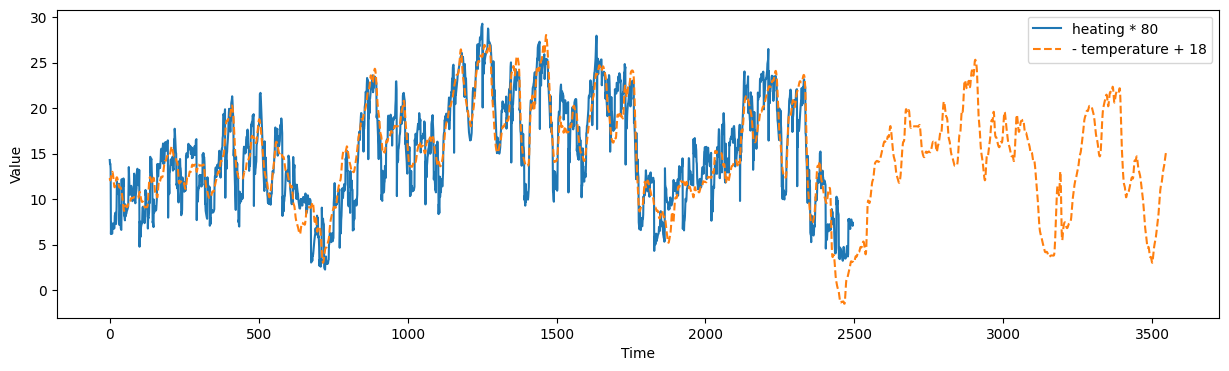

In [11]:
# First, we look at heating loads
# We transform the consumption of heating and temperature to make a (almost) perfect match
# This indicates that temperature would play a key role for the forecasting of the heating load
plt.figure(figsize=(15, 4))
plt.plot(np.array(consumption_heating.values * 80), label='heating * 80')
plt.plot(-interpolated_arr + 18, linestyle='--', label='- temperature + 18')
plt.legend()
_ = plt.xlabel('Time')
_ = plt.ylabel('Value')
plt.show()

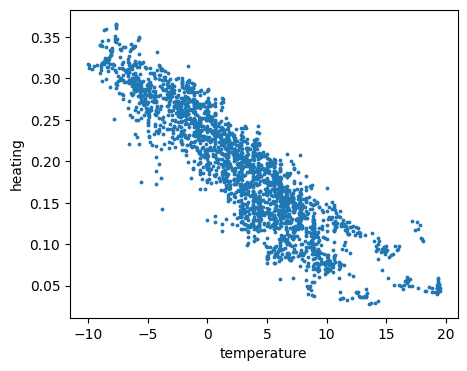

In [12]:
# We add a scatter plot of heating cost against temperature to observe the negative correlation between them
plt.figure(figsize=(5, 4))
plt.scatter(interpolated_arr[:len(consumption_heating.values)], np.array(consumption_heating.values), s=3)
_ = plt.xlabel('temperature')
_ = plt.ylabel('heating')
plt.show()

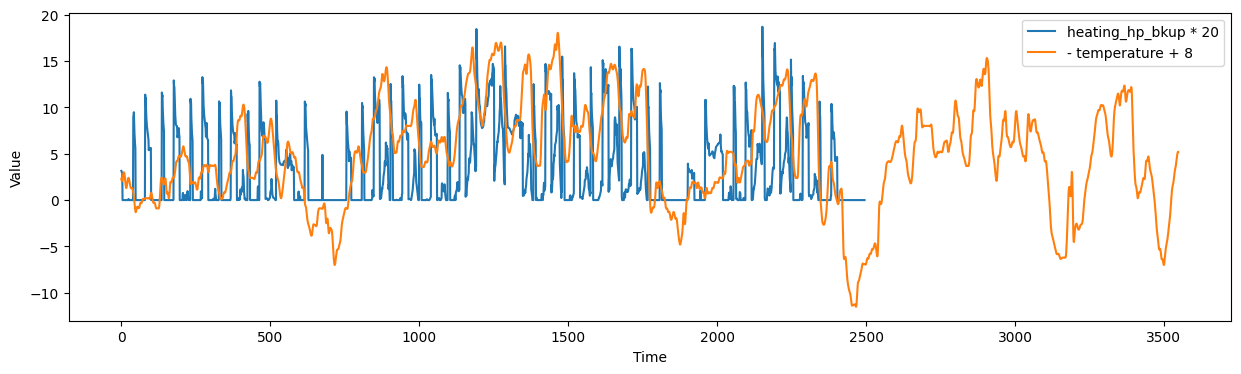

In [13]:
# Next is heating_hp_bkup, the relationship is not that clear, but still visible
# In general, a lower temperature means a higher consumption, and a high temperature may lead to a time range with no consumption
# In addition, the consumption is highly related to time of day, which would also play a major role in the forecasting of the loads
plt.figure(figsize=(15, 4))
plt.plot(np.array(consumption_heating_hp_bkup.values * 20), label='heating_hp_bkup * 20')
plt.plot(-interpolated_arr + 8, label='- temperature + 8')
plt.legend()
_ = plt.xlabel('Time')
_ = plt.ylabel('Value')

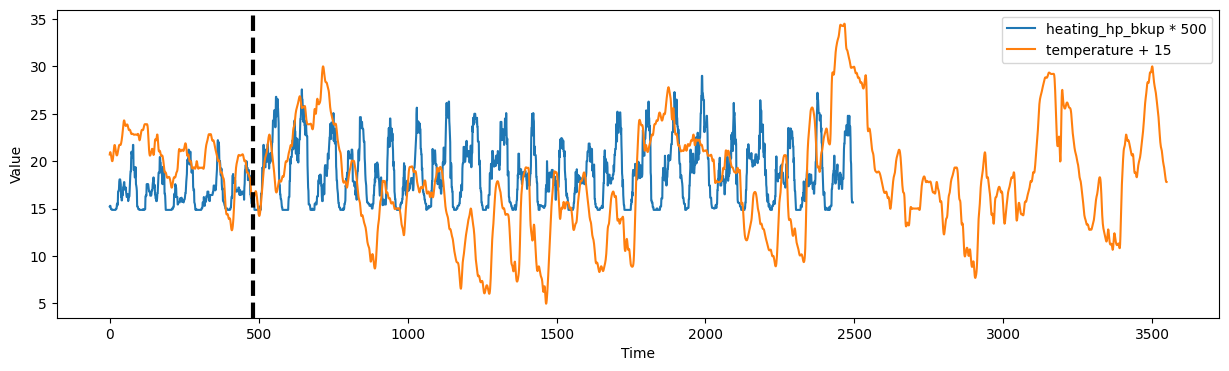

In [14]:
# Next is plug loads, whose relationship with temperature is hard to interpret
# Still, we try to align the two quantities in the figure.
# It can be seen that the days with the highest peaks of plug loads is close to some high-temperature dates, but the correlation is weak in general
plt.figure(figsize=(15, 4))
plt.plot(np.array(consumption_plug_loads.values * 500), label='heating_hp_bkup * 500')
plt.plot(interpolated_arr + 15, label='temperature + 15')

# We add a vertical line corresponding to the beginning of 2018-12-01. It is clear that the distribution of the load changes afterwards.
plt.axvline(24 * 4 * 5, linestyle='--', linewidth=3, color='k')

plt.legend()
_ = plt.xlabel('Time')
_ = plt.ylabel('Value')

### Modeling part I: heating

As previously mentioned, temperature and time are the key factors for making the forecasts. We will first create some features based on temperature and time information, and then use the LightGBM model to implement the load forecasting task.

In [15]:
# Prepare the df_heating dataframe and create the temperature column
start_date = '2018-11-26 00:15:00'
end_date = '2019-01-01 00:15:00'
df_heating = df_scrooge_new[(df_scrooge_new['timestamp'] >= start_date) & (df_scrooge_new['timestamp'] < end_date)] \
             [['timestamp', 'out.electricity.heating.energy_consumption']].reset_index(drop=True)
df_heating['temperature'] = interpolated_arr[:len(df_heating)]

# Calculate the number of data samples that is available
LEN_AVAILABLE = (5 + 21) * 24 * 4

Before jumping into the implementation of the lightGBM model, we first introduce the idea of <i> temperature-threshold-and-time-related target encoding features</i>. A major insight behind this idea comes from the observation that the heating load drops dramatically close to where the temperature exceeds the threshold of (nearly) 10 degrees. Further, when the temperature reaches 15 degrees, the dip is even more visible.

As we are looking for the time window with the lowest energy consumption, this observation becomes quite valuable. Yet another important observation is that we can see another time period where temperature exceeds the threshold of 10 degrees in the next few days to be forecasted.

Text(0, 0.5, 'Value')

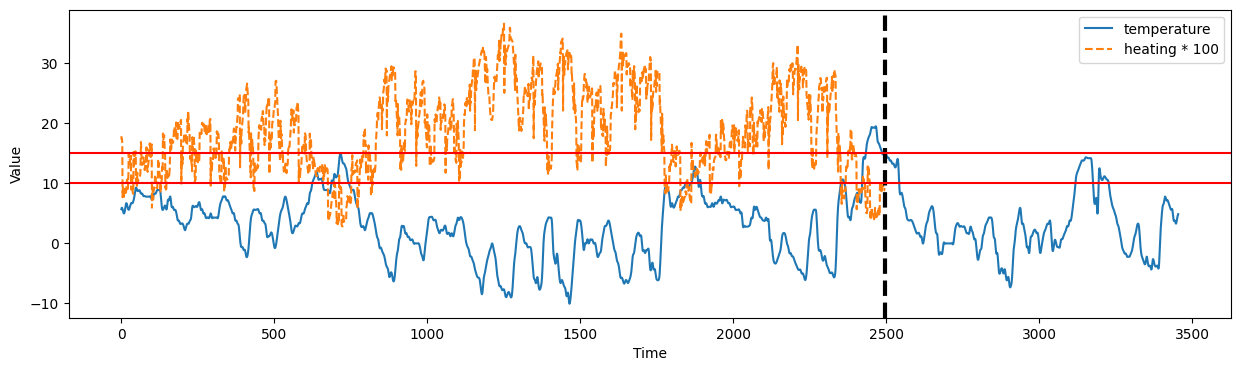

In [16]:
# Plot the temperature and heating load with the horizontal lines corresponding to 10 dgrees and 15 degrees highlighted
# The dashed black vertical line splits the past and the future
plt.figure(figsize=(15, 4))
plt.plot(df_heating['temperature'], label='temperature')
plt.plot(df_heating['out.electricity.heating.energy_consumption'] * 100, linestyle='--', label='heating * 100')
plt.axvline(LEN_AVAILABLE, linestyle='--', color='k', linewidth=3)
plt.legend()
plt.axhline(10, color='r')
plt.axhline(15, color='r')
plt.xlabel('Time')
plt.ylabel('Value')

We further observe the statistics of heating load under several temperature-threshold conditions, namely, all temperatures, temperature greater than 5 degress Celcius, and temperature greater than 10 degrees Celcius, respectively.

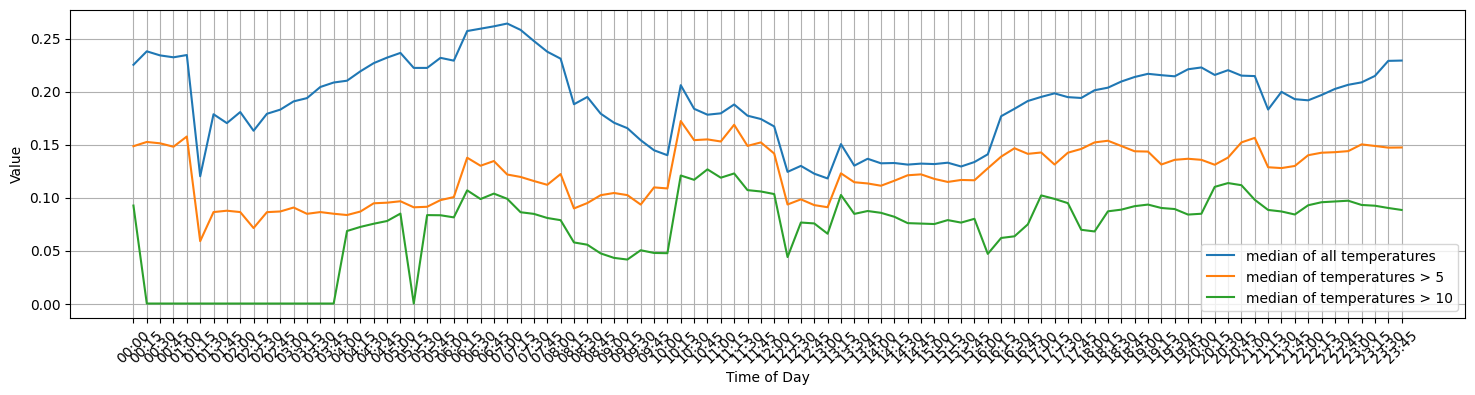

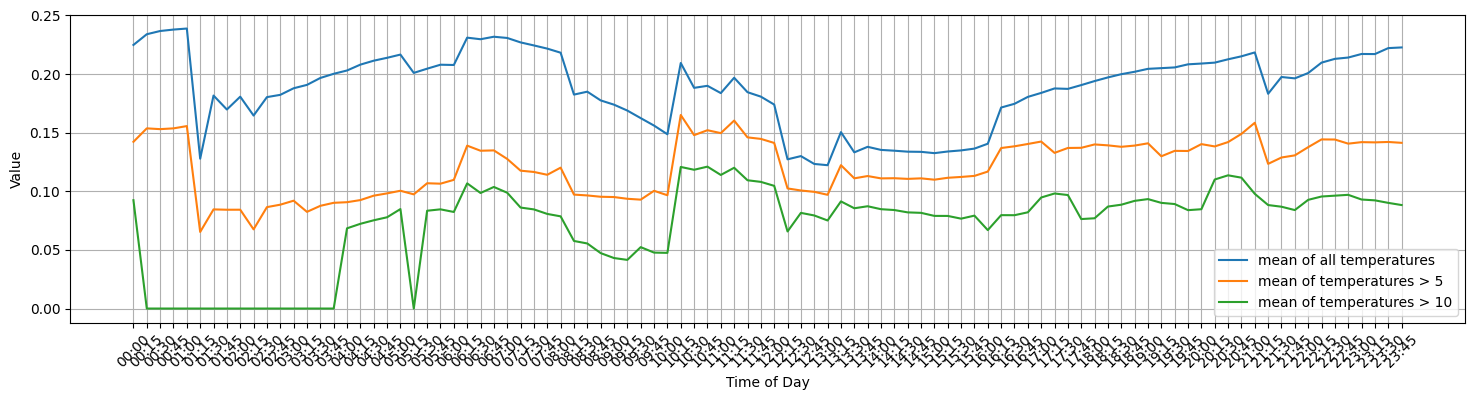

In [17]:
# Create the 'hour_minute' column to be partitioned upon
df_heating['hour_minute'] = df_heating['timestamp'].dt.strftime('%H:%M')

# The 'all temperatures' condition
grouped_temp_all = df_heating[:LEN_AVAILABLE].groupby('hour_minute')['out.electricity.heating.energy_consumption']

# The 'temperature greater than 5 degress Celcius' condition
df_heating_temp_gt_5 = df_heating[:LEN_AVAILABLE][df_heating[:LEN_AVAILABLE].temperature > 5].copy()
grouped_temp_gt_5 = df_heating_temp_gt_5.groupby('hour_minute')['out.electricity.heating.energy_consumption']

# The 'temperature greater than 10 degrees Celcius' condition 
df_heating_temp_gt_10 = df_heating[:LEN_AVAILABLE][df_heating[:LEN_AVAILABLE].temperature > 10].copy()
grouped_temp_gt_10 = df_heating_temp_gt_10[:LEN_AVAILABLE].groupby('hour_minute')['out.electricity.heating.energy_consumption']

# Create a list of all hour-minute combinations
all_hour_minutes = [name for name, _ in df_heating[:LEN_AVAILABLE].groupby('hour_minute')]

# Create dicts of hour-minite combinations and loads for different conditions
data_temp_all_dict = {hour_minute: [] for hour_minute in all_hour_minutes}
data_temp_gt_5_dict = {hour_minute: [] for hour_minute in all_hour_minutes}
data_temp_gt_10_dict = {hour_minute: [] for hour_minute in all_hour_minutes}

# Fill the dicts with grouped loads
for hour_minute, group in grouped_temp_all:
    data_temp_all_dict[hour_minute] = group.tolist()

for hour_minute, group in grouped_temp_gt_5:
    data_temp_gt_5_dict[hour_minute] = group.tolist()

for hour_minute, group in grouped_temp_gt_10:
    data_temp_gt_10_dict[hour_minute] = group.tolist()

# Use the dicts to generate lists of load values partitioned by time intervals
# As there are time intervals with no samples for temperature greater than 10 degrees, we fill them with zeros
data_temp_all = [data_temp_all_dict[hour_minute] for hour_minute in all_hour_minutes]
data_temp_gt_5 = [data_temp_gt_5_dict[hour_minute] for hour_minute in all_hour_minutes]
data_temp_gt_10 = [data_temp_gt_10_dict[hour_minute] if data_temp_gt_10_dict[hour_minute] else [0] for hour_minute in all_hour_minutes]

# Calculate medians and means
medians_temp_all = [np.median(d) if d else 0 for d in data_temp_all]  
means_temp_all = [np.mean(d) if d else 0 for d in data_temp_all]

medians_temp_gt_5 = [np.median(d) if d else 0 for d in data_temp_gt_5]
means_temp_gt_5 = [np.mean(d) if d else 0 for d in data_temp_gt_5]

medians_temp_gt_10 = [np.median(d) if d else 0 for d in data_temp_gt_10]
means_temp_gt_10 = [np.mean(d) if d else 0 for d in data_temp_gt_10]

# Plot median values
plt.figure(figsize=(18, 4))
plt.plot(medians_temp_all, label='median of all temperatures')
plt.plot(medians_temp_gt_5, label='median of temperatures > 5')
plt.plot(medians_temp_gt_10, label='median of temperatures > 10')
_ = plt.xticks(range(len(data_temp_all)), grouped_temp_all.groups.keys(), rotation=45)

plt.legend()
plt.xlabel('Time of Day')
plt.ylabel('Value')
plt.grid(True)
plt.show()

# Plot mean values
plt.figure(figsize=(18, 4))
plt.plot(means_temp_all, label='mean of all temperatures')
plt.plot(means_temp_gt_5, label='mean of temperatures > 5')
plt.plot(means_temp_gt_10, label='mean of temperatures > 10')
_ = plt.xticks(range(len(data_temp_all)), grouped_temp_all.groups.keys(), rotation=45)

plt.legend()
plt.xlabel('Time of Day')
plt.ylabel('Value')
plt.grid(True)
plt.show()

From the figures above, we can clearly see that when all temperatures are considered, the heating load rises at 16:15 in the afternoon all the way to 01:00 near midnight. It then drops rapidly and start to rise again until 07:00 in the morning. For conditions where temperatures are higher than 5 or 10 degrees, the upward trends in the afternoon are less visible. For the condition where temperatures are higher than 10 degrees, particularly, the load profile is quite flat throughout the day. 

Thus, adding the temperature-threshold-and-time-related target encoding features may help the model better capture the relationship between temperature and load.

Next, we build the lightGBM for heating loads. We first create a pool of features and keep some of them. The weights of some samples are modified as well. The hyper-parameters of the model is kept simple as the size of the training dataset is quite small.

In [18]:
# Obtain hour, minute, and weekday columns
df_heating['hour'] = df_heating['timestamp'].dt.hour
df_heating['minute'] = df_heating['timestamp'].dt.minute
df_heating['weekday'] = df_heating['timestamp'].dt.weekday

# Calculate intra-day cyclic features 
df_heating['hour_angle'] = (2 * np.pi * (df_heating['hour'] + df_heating['minute'] / 60)) / 24
df_heating['sin_day'] = np.sin(df_heating['hour_angle'])
df_heating['cos_day'] = np.cos(df_heating['hour_angle'])
df_heating['15_min_interval'] = (df_heating['hour'] * 60 + df_heating['minute']) // 15

# Calculate intra-week cyclic features
df_heating['week_angle'] = (2 * np.pi * (df_heating['weekday'] + (df_heating['hour'] + df_heating['minute'] / 60) / 24)) / 7
df_heating['sin_week'] = np.sin(df_heating['week_angle'])
df_heating['cos_week'] = np.cos(df_heating['week_angle'])
df_heating['is_weekend'] = (df_heating['weekday'] >= 5).astype(int)

# Create some temperature-threshold-and-time-related target encoding features
# Note that the train-test split here is only for the feature generation purpose
train_proportion = 1 # Use the entire training dataset for target encoding
LEN_TRAIN = int(train_proportion * LEN_AVAILABLE)
df_heating_train = df_heating[:LEN_TRAIN].copy()  
df_heating_test = df_heating[LEN_TRAIN:].copy()

# Calculate target encoding values for the training dataset
mean_encoded_features = {}
for temperature_threshold in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]:
    # Calculate the mean load for each feature
    df_heating_train_ = df_heating_train[df_heating_train.temperature >= temperature_threshold].copy()
    mean_encoded = df_heating_train_.groupby('15_min_interval')['out.electricity.heating.energy_consumption'].mean()
    new_index = range(0, 96)
    mean_encoded = mean_encoded.reindex(new_index, fill_value=0)
    mean_encoded_features[temperature_threshold] = mean_encoded

    # Ensure that the specific column exists, otherwise create the column
    col_name = f'te_{temperature_threshold}'
    if col_name not in df_heating_train.columns:
        df_heating_train[col_name] = 0  # Use 0 as the default value

    # Apply target encoding to the training dataset
    df_heating_train.loc[df_heating_train.temperature >= temperature_threshold, col_name] = \
    df_heating_train.loc[df_heating_train.temperature >= temperature_threshold, '15_min_interval'].map(mean_encoded)

# Apply target encoding to the test dataset
for temperature_threshold in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]:
    # Ensure that the specific column exists, otherwise create the column
    col_name = f'te_{temperature_threshold}'
    if col_name not in df_heating_test.columns:
        df_heating_test[col_name] = 0  # Use 0 as the default value
        
    df_heating_test.loc[df_heating_test.temperature >= temperature_threshold, col_name] = \
    df_heating_test.loc[df_heating_test.temperature >= temperature_threshold, '15_min_interval'].map(mean_encoded_features[temperature_threshold])
    
# Concat the two parts into the original dataframe
df_heating = pd.concat([df_heating_train, df_heating_test], axis=0)  

# Create the training and test dataset for the lightGBM model with the selected features
X = df_heating[['15_min_interval', 'is_weekend', 'temperature', 'te_5', 'te_10', 'te_15']]

# Split the dataset into the available part and the part for forecasting
X_available = X[:LEN_AVAILABLE]
X_test = X[LEN_AVAILABLE:]

# Split the available part into training and validation sets
train_proportion = 1 # The training dataset has a proportion of 1, thus the validation dataset is empty
LEN_TRAIN = int(train_proportion * len(X_available))
X_train = X_available[:LEN_TRAIN]
X_valid = X_available[LEN_TRAIN:]

# Create the target values for training and validation sets
y = df_heating['out.electricity.heating.energy_consumption']
y_train = y[:LEN_TRAIN]
y_valid = y[LEN_TRAIN:LEN_AVAILABLE]

# Set some sample weights: higher weights are given to samples with lower temperatures
sample_weights = np.ones(len(y_train))
sample_weights[X_train.temperature < 10] = 2
sample_weights[X_train.temperature < 5] = 3
sample_weights[X_train.temperature < 0] = 4
sample_weights[2399:] = 0.15 # Reduce the weight for 2018-12-21 as the temperature is too high

# Create the lightGBM datasets
lgb_dataset = lgb.Dataset(data=X_train, label=y_train, weight=sample_weights, free_raw_data=False)
lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_dataset)

# The parameters of the lightGBM model
# We use a set of super simple parameters as the nunber of samples in the training dataset is quite limited
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 31,
    'learning_rate': 0.01,
    'bagging_freq': 0
}

# Train the lightGBM model (or load the model)
if DO_TRAIN:
    lgb_model = lgb.train(params, lgb_dataset, num_boost_round=380)
    lgb_model.save_model('./model_heating.txt')
else:
    lgb_model = lgb.Booster(model_file='./model_heating.txt')
    
# Forecast with the lightGBM model
predictions_heating_lgb_test = lgb_model.predict(X_test)
predictions_heating_lgb_test = np.clip(predictions_heating_lgb_test, 0, None)

### Modeling part II: heating_hp_bkup

We carry on and model the heating_hp_bkup loads.

In [19]:
# Prepare the df_heating_hp_bkup dataframe and create the temperature column
start_date = '2018-11-26 00:15:00'
end_date = '2019-01-01 00:15:00'
df_heating_hp_bkup = df_scrooge_new[(df_scrooge_new['timestamp'] >= start_date) & (df_scrooge_new['timestamp'] < end_date)] \
                     [['timestamp', 'out.electricity.heating_hp_bkup.energy_consumption']].reset_index(drop=True)
df_heating_hp_bkup['temperature'] = interpolated_arr[:len(df_heating_hp_bkup)]

# Calculate the number of data samples that is available
LEN_AVAILABLE = (5 + 21) * 24 * 4

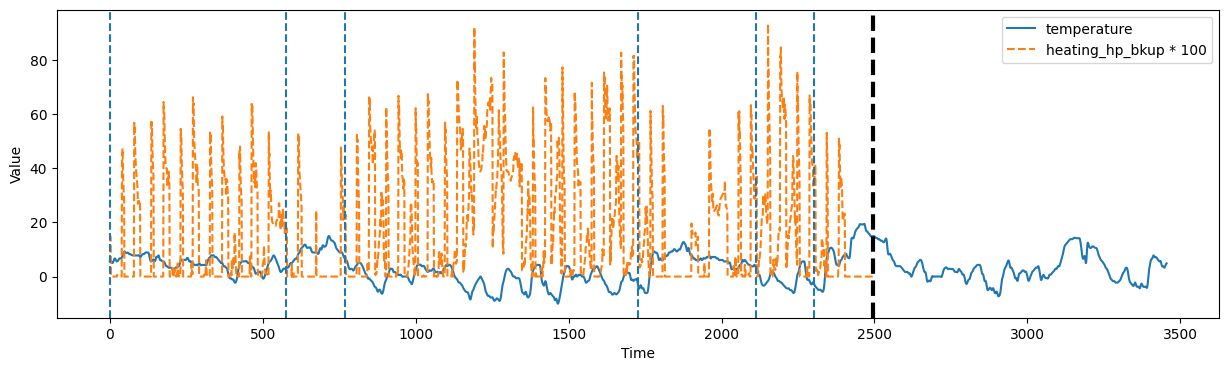

In [20]:
# Plot the temperature and heating_hp_bkup load
# The dashed black vertical line splits the past and the future
plt.figure(figsize=(15, 4))
plt.plot(df_heating_hp_bkup['temperature'], label='temperature')
plt.plot(df_heating_hp_bkup['out.electricity.heating_hp_bkup.energy_consumption'] * 100, linestyle='--', label='heating_hp_bkup * 100')
plt.axvline(LEN_AVAILABLE, linestyle='--', color='k', linewidth=3)

# We also identify several sections with relatively lower temperature and higher variation of the load
# From 2018-11-26 to 2018-12-01
plt.axvline(0, linestyle='--')
plt.axvline(576, linestyle='--')

# From 2018-12-04 to 2018-12-13
plt.axvline(768, linestyle='--')
plt.axvline(1728, linestyle='--')

# From 2018-12-18 to 2018-12-19
plt.axvline(2112, linestyle='--')
plt.axvline(2304, linestyle='--')

plt.legend()
_ = plt.xlabel('Time')
_ = plt.ylabel('Value')

Next, we build the lightGBM for heating_hp_bkup loads. We first create a pool of features and keep some of the features. The weights of some samples are modified as well. The hyper-parameters of the model is kept simple as the size of the training dataset is quite small.

In [21]:
# Obtain hour, minute, and weekday columns
df_heating_hp_bkup['hour'] = df_heating_hp_bkup['timestamp'].dt.hour
df_heating_hp_bkup['minute'] = df_heating_hp_bkup['timestamp'].dt.minute
df_heating_hp_bkup['weekday'] = df_heating_hp_bkup['timestamp'].dt.weekday

# Calculate intra-day cyclic features 
df_heating_hp_bkup['hour_angle'] = (2 * np.pi * (df_heating_hp_bkup['hour'] + df_heating_hp_bkup['minute'] / 60)) / 24
df_heating_hp_bkup['sin_day'] = np.sin(df_heating_hp_bkup['hour_angle'])
df_heating_hp_bkup['cos_day'] = np.cos(df_heating_hp_bkup['hour_angle'])
df_heating_hp_bkup['15_min_interval'] = (df_heating_hp_bkup['hour'] * 60 + df_heating_hp_bkup['minute']) // 15

# Calculate intra-week cyclic features
df_heating_hp_bkup['week_angle'] = (2 * np.pi * (df_heating_hp_bkup['weekday'] + (df_heating_hp_bkup['hour'] + df_heating_hp_bkup['minute'] / 60) / 24)) / 7
df_heating_hp_bkup['sin_week'] = np.sin(df_heating_hp_bkup['week_angle'])
df_heating_hp_bkup['cos_week'] = np.cos(df_heating_hp_bkup['week_angle'])
df_heating_hp_bkup['is_weekend'] = (df_heating_hp_bkup['weekday'] >= 5).astype(int)

# Create some temperature-threshold-and-time-related target encoding features
# Note that the train-test split here is only for the feature generation purpose
train_proportion = 1
LEN_TRAIN = int(train_proportion * LEN_AVAILABLE)
df_heating_hp_bkup_train = df_heating_hp_bkup[:LEN_TRAIN].copy()  
df_heating_hp_bkup_test = df_heating_hp_bkup[LEN_TRAIN:].copy()

# Calculate target encoding values for the training dataset
mean_encoded_features = {}
for temperature_threshold in [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]:
    # Calculate the mean load for each feature
    df_heating_hp_bkup_train_ = df_heating_hp_bkup_train[df_heating_train.temperature >= temperature_threshold].copy()
    mean_encoded = df_heating_hp_bkup_train_.groupby('15_min_interval')['out.electricity.heating_hp_bkup.energy_consumption'].mean()
    new_index = range(0, 96)
    mean_encoded = mean_encoded.reindex(new_index, fill_value=0)
    mean_encoded_features[temperature_threshold] = mean_encoded

    # Ensure that the specific column exists, otherwise create the column
    col_name = f'te_{temperature_threshold}'
    if col_name not in df_heating_hp_bkup_train.columns:
        df_heating_hp_bkup_train[col_name] = 0  # Use 0 as the default value

    # Apply target encoding to the training dataset
    df_heating_hp_bkup_train.loc[df_heating_hp_bkup_train.temperature >= temperature_threshold, col_name] = \
    df_heating_hp_bkup_train.loc[df_heating_hp_bkup_train.temperature >= temperature_threshold, '15_min_interval'].map(mean_encoded)

# Apply target encoding to the test dataset
for temperature_threshold in [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]:
    # Ensure that the specific column exists, otherwise create the column
    col_name = f'te_{temperature_threshold}'
    if col_name not in df_heating_hp_bkup_test.columns:
        df_heating_hp_bkup_test[col_name] = 0  # Use 0 as the default value
        
    df_heating_hp_bkup_test.loc[df_heating_hp_bkup_test.temperature >= temperature_threshold, col_name] = \
    df_heating_hp_bkup_test.loc[df_heating_hp_bkup_test.temperature >= temperature_threshold, '15_min_interval'] \
    .map(mean_encoded_features[temperature_threshold])
    
# Concat the two parts into the original dataframe
df_heating_hp_bkup = pd.concat([df_heating_hp_bkup_train, df_heating_hp_bkup_test], axis=0)  

# Create the training and test dataset for the lightGBM model with the selected features
X = df_heating_hp_bkup[['sin_day', 'cos_day', '15_min_interval', 'is_weekend', 'temperature', 'te_5', 'te_10', 'te_15']]

# Split the dataset into the available part and the part for forecasting
X_available = X[:LEN_AVAILABLE]
X_test = X[LEN_AVAILABLE:]

# Split the available part into training and validation sets
train_proportion = 1 # The training dataset has a proportion of 1, thus the validation dataset is empty
LEN_TRAIN = int(train_proportion * len(X_available))
X_train = X_available[:LEN_TRAIN]
X_valid = X_available[LEN_TRAIN:]

# Create the target values for training and validation sets
y = df_heating_hp_bkup['out.electricity.heating_hp_bkup.energy_consumption']
y_train = y[:LEN_TRAIN]
y_valid = y[LEN_TRAIN:LEN_AVAILABLE]

# Set some sample weights: we assign higher weights to windows with higher load variations
sample_weights = np.ones(len(y_train))
sample_weights[0: 576] = 1.75
sample_weights[768: 1728] = 1.75
sample_weights[2112: 2304] = 1.75
sample_weights[2399:] = 0.15 # Reduce the weight for 2018-12-21 as the temperature is too high

# Create the lightGBM datasets
lgb_dataset = lgb.Dataset(data=X_train, label=y_train, weight=sample_weights, free_raw_data=False)
lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_dataset)

# The parameters of the lightGBM model
# We use a set of super simple parameters as the nunber of samples in the training dataset is quite limited
params = {
    'objective': 'regression',
    'metric': 'tweedie',
    'tweedie_variance_power': 1.2,
    'num_leaves': 31,
    'learning_rate': 0.01,
}

# Train the lightGBM model (or load the model)
if DO_TRAIN:
    lgb_model = lgb.train(params, lgb_dataset, num_boost_round=380)
    lgb_model.save_model('./model_heating_hp_bkup.txt')
else:
    lgb_model = lgb.Booster(model_file='./model_heating_hp_bkup.txt')

# Forecast with the lightGBM model
predictions_heating_hp_bkup_lgb_test = lgb_model.predict(X_test)
predictions_heating_hp_bkup_lgb_test = np.clip(predictions_heating_hp_bkup_lgb_test, 0, None)

### Modeling part III: plug_loads

We carry on and model the plug_loads. As is stated previously, as the distribution of the plug loads has a significant shift starting from 2018-12-01, we set the start date of data to 2018-12-01.

In [22]:
# Prepare the df_plug_loads dataframe and create the temperature column
start_date = '2018-12-01 00:15:00'
end_date = '2019-01-01 00:15:00'
df_plug_loads = df_scrooge_new[(df_scrooge_new['timestamp'] >= start_date) & (df_scrooge_new['timestamp'] < end_date)] \
                [['timestamp', 'out.electricity.plug_loads.energy_consumption']].reset_index(drop=True)
df_plug_loads['temperature'] = interpolated_arr[5 * 24 * 4:5 * 24 * 4 + len(df_plug_loads)]

# Calculate the number of data samples that is available
LEN_AVAILABLE = 21 * 24 * 4

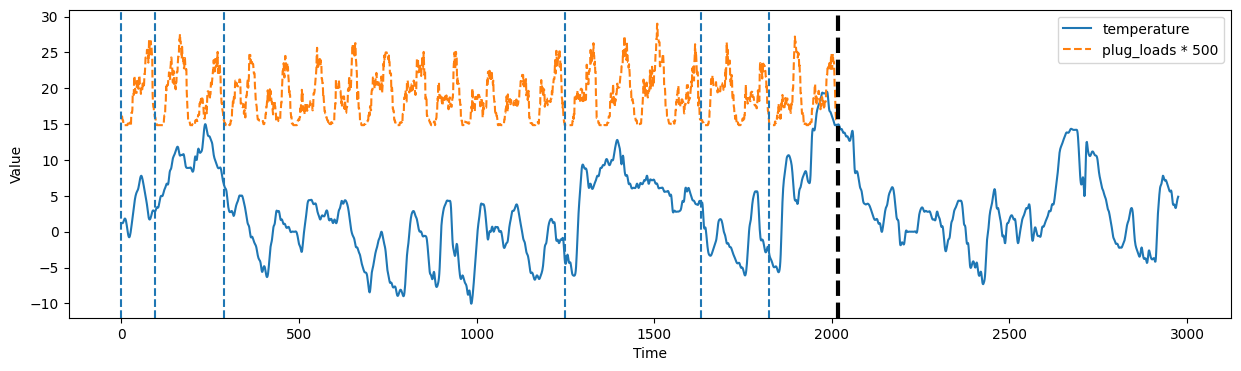

In [23]:
# Plot the temperature and plug loads
# The dashed black vertical line splits the past and the future
plt.figure(figsize=(15, 4))
plt.plot(df_plug_loads['temperature'], label='temperature')
plt.plot(df_plug_loads['out.electricity.plug_loads.energy_consumption'] * 500, linestyle='--', label='plug_loads * 500')
plt.axvline(LEN_AVAILABLE, linestyle='--', color='k', linewidth=3)

# We also identify several sections with relatively lower temperature and higher variation of the load
# Shift the ranges 5 days ahead as we are now using 5 days fewer than previous models
shift = 5 * 24 * 4
# From 2018-11-26 to 2018-12-01
plt.axvline(0, linestyle='--')
plt.axvline(576 - shift, linestyle='--')

# From 2018-12-04 to 2018-12-13
plt.axvline(768 - shift, linestyle='--')
plt.axvline(1728 - shift, linestyle='--')

# From 2018-12-18 to 2018-12-19
plt.axvline(2112 - shift, linestyle='--')
plt.axvline(2304 - shift, linestyle='--')

plt.legend()
_ = plt.xlabel('Time')
_ = plt.ylabel('Value')

Next, we build the lightGBM for plug loads. We first create a pool of features and keep some of the features. The weights of some samples are modified as well. The hyper-parameters of the model is kept simple as the size of the training dataset is quite small.

In [24]:
# Obtain hour, minute, and weekday columns
df_plug_loads['hour'] = df_plug_loads['timestamp'].dt.hour
df_plug_loads['minute'] = df_plug_loads['timestamp'].dt.minute
df_plug_loads['weekday'] = df_plug_loads['timestamp'].dt.weekday

# Calculate intra-day cyclic features 
df_plug_loads['hour_angle'] = (2 * np.pi * (df_plug_loads['hour'] + df_plug_loads['minute'] / 60)) / 24
df_plug_loads['sin_day'] = np.sin(df_plug_loads['hour_angle'])
df_plug_loads['cos_day'] = np.cos(df_plug_loads['hour_angle'])
df_plug_loads['15_min_interval'] = (df_plug_loads['hour'] * 60 + df_plug_loads['minute']) // 15

# Calculate intra-week cyclic features
df_plug_loads['week_angle'] = (2 * np.pi * (df_plug_loads['weekday'] + (df_plug_loads['hour'] + df_plug_loads['minute'] / 60) / 24)) / 7
df_plug_loads['sin_week'] = np.sin(df_plug_loads['week_angle'])
df_plug_loads['cos_week'] = np.cos(df_plug_loads['week_angle'])
df_plug_loads['is_weekend'] = (df_plug_loads['weekday'] >= 5).astype(int)

# Create some target encoding features
# For plug loads, in addition to temperature-threshold-and-time-related features, we also create some additional time-related target encoding features 
# Note that the train-test split here is only for the feature generation purpose
train_proportion = 0.8
LEN_TRAIN = int(train_proportion * LEN_AVAILABLE)
df_plug_loads_train = df_plug_loads[:LEN_TRAIN].copy()  
df_plug_loads_test = df_plug_loads[LEN_TRAIN:].copy()

# Temperature-threshold-related target encoding features
# Calculate target encoding values for the training dataset 
mean_encoded_features = {}
for temperature_threshold in [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]:
    # Calculate the mean load for each feature
    df_plug_loads_train_ = df_plug_loads_train[df_heating_train.temperature[:len(df_plug_loads_train)] >= temperature_threshold].copy()
    mean_encoded = df_plug_loads_train_.groupby('15_min_interval')['out.electricity.plug_loads.energy_consumption'].mean()
    new_index = range(0, 96)
    mean_encoded = mean_encoded.reindex(new_index, fill_value=0)
    mean_encoded_features[temperature_threshold] = mean_encoded

    # Ensure that the specific column exists, otherwise create the column
    col_name = f'te_{temperature_threshold}'
    if col_name not in df_plug_loads_train.columns:
        df_plug_loads_train[col_name] = 0  # Use 0 as the default value

    # Apply target encoding to the training dataset
    df_plug_loads_train.loc[df_plug_loads_train.temperature >= temperature_threshold, col_name] = \
    df_plug_loads_train.loc[df_plug_loads_train.temperature >= temperature_threshold, '15_min_interval'].map(mean_encoded)

# Apply target encoding to the test dataset
for temperature_threshold in [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]:
# For temperature_threshold in [5, 10]:
    # Ensure that the specific column exists, otherwise create the column
    col_name = f'te_{temperature_threshold}'
    if col_name not in df_plug_loads_test.columns:
        df_plug_loads_test[col_name] = 0  # Use 0 as the default value
        
    df_plug_loads_test.loc[df_plug_loads_test.temperature >= temperature_threshold, col_name] = \
    df_plug_loads_test.loc[df_plug_loads_test.temperature >= temperature_threshold, '15_min_interval'].map(mean_encoded_features[temperature_threshold])

# Time-related target encoding features (without considering temperature thresholds)
# Calculate target encoding values for the training dataset
mean_encoded_features = {}
for feature in ['15_min_interval', 'hour', 'weekday', 'is_weekend']:
    # Calculate the mean load for each feature
    mean_encoded = df_plug_loads_train.groupby(feature)['out.electricity.plug_loads.energy_consumption'].mean()
    mean_encoded_features[feature] = mean_encoded

    # Apply target encoding to the training dataset
    df_plug_loads_train.loc[:, f'te_{feature}'] = df_plug_loads_train[feature].map(mean_encoded)

# Apply target encoding to the test dataset
for feature in ['15_min_interval', 'hour', 'weekday', 'is_weekend']:
    df_plug_loads_test.loc[:, f'te_{feature}'] = df_plug_loads_test[feature].map(mean_encoded_features[feature])
    
# Concat the two parts into the original dataframe
df_plug_loads = pd.concat([df_plug_loads_train, df_plug_loads_test], axis=0)    

# Create the training and test dataset for the lightGBM model with the selected features
X = df_plug_loads[['sin_day', 'cos_day', '15_min_interval', 'weekday', 'is_weekend', 'temperature',
                   'te_hour', 'te_weekday', 'te_is_weekend', 'te_15_min_interval', 'te_5', 'te_10', 'te_15']]

# Split the dataset into the available part and the part for forecasting
X_available = X[:LEN_AVAILABLE]
X_test = X[LEN_AVAILABLE:]

# Split the available part into training and validation sets
train_proportion = 0.8 # The training dataset has a proportion of 0.8, thus the validation dataset has a proportion of 0.2
LEN_TRAIN = int(train_proportion * len(X_available))
X_train = X_available[:LEN_TRAIN]
X_valid = X_available[LEN_TRAIN:]

# Create the target values for training and validation sets
y = df_plug_loads['out.electricity.plug_loads.energy_consumption']
y_train = y[:LEN_TRAIN]
y_valid = y[LEN_TRAIN:LEN_AVAILABLE]

# Set some sample weights: we assign higher weights to windows with higher load variations
sample_weights = np.ones(len(y_train))
shift = 5 * 24 * 4 # Shift the ranges 5 days ahead as we are now using 5 days fewer than previous models
sample_weights[0 : 576 - shift] = 1.4
sample_weights[768 - shift : 1728 - shift] = 1.4
sample_weights[2112 - shift : 2304 - shift] = 1.4

# Create the lightGBM datasets
lgb_dataset = lgb.Dataset(data=X_train, label=y_train, weight=sample_weights, free_raw_data=False)
lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_dataset)

# The parameters of the lightGBM model
# We use a set of super simple parameters as the nunber of samples in the training dataset is quite limited
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 31,
    'learning_rate': 0.01,
    'random_state': 2024,
}

# Train the lightGBM model (or load the model)
if DO_TRAIN:
    lgb_model = lgb.train(params, lgb_dataset, num_boost_round=1000, valid_sets=lgb_eval, early_stopping_rounds=200, verbose_eval=100)
    lgb_model.save_model('./model_plug_loads.txt')
else:
    lgb_model = lgb.Booster(model_file='./model_plug_loads.txt')

# Forecast with the lightGBM model
predictions_plug_loads_lgb = lgb_model.predict(X_valid)
predictions_plug_loads_lgb_test = lgb_model.predict(X_test)
predictions_plug_loads_lgb_test = np.clip(predictions_plug_loads_lgb_test, 0, None)

### Finding the window with the lowest party cost

After forecasting the above-mentioned loads, it is time to formulate the party load and find the four-hour window that offers the most cost-effective electricity rates for Scrooge's Party.

In [25]:
# Put forecasts into the df_scrooge_new dataframe
df_scrooge_new.loc[len(df_scrooge_new) - 960:len(df_scrooge_new):, 'out.electricity.heating_hp_bkup.energy_consumption'] = \
list(predictions_heating_hp_bkup_lgb_test)
df_scrooge_new.loc[len(df_scrooge_new) - 960:len(df_scrooge_new):, 'out.electricity.heating.energy_consumption'] = \
list(predictions_heating_lgb_test)
df_scrooge_new.loc[len(df_scrooge_new) - 960:len(df_scrooge_new):, 'out.electricity.plug_loads.energy_consumption'] = \
list(predictions_plug_loads_lgb_test)

# Calculate the increased load
df_scrooge_new['increase'] = 0.3 * (df_scrooge_new['out.electricity.heating_hp_bkup.energy_consumption'] 
                                    + df_scrooge_new['out.electricity.heating.energy_consumption'] 
                                    + df_scrooge_new['out.electricity.plug_loads.energy_consumption'])

In [26]:
# Calculate the party cost
def calculate_rate(timestamp):
    """ Calculate the electricity rate according to the input timestamp."""
    # Transform timestamp into hour
    # As the end time of the 15-minute interval is used to represent the interval, 
    # we subtract 15 minutes from the time so that we can use hour to distinguish the rates
    hour = (timestamp - pd.Timedelta(minutes=15)).hour
    # 18:00 (6pm) to 22:00 (10pm): 0.35
    if 18 <= hour < 22:
        return 0.35
    # Otherwise: 0.2
    else:
        return 0.2

# Apply rate caculation to the dataframe
df_scrooge_new['rate'] = df_scrooge_new['timestamp'].apply(calculate_rate)

# Calculate cost
df_scrooge_new['cost'] = df_scrooge_new['rate'] * (df_scrooge_new['increase'] + 2 / 4)

In [27]:
# Filter out the data within the forecast horizon
mask_date = (df_scrooge_new['timestamp'] >= '2018-12-22 17:00:00') & (df_scrooge_new['timestamp'] < '2018-12-31 00:00:00')
df_date_range = df_scrooge_new[mask_date].copy()

# Calculate total costs of 4-hour windows
df_date_range['rolling_sum'] = df_date_range['cost'].rolling(window=16, min_periods=1, closed='right').sum()

# Calculate the start time and end time of the windows
df_date_range['window_start'] = df_date_range['timestamp'] - pd.Timedelta(hours=4)
df_date_range['window_end'] = df_date_range['timestamp']

# Keep windows within 17:00 to 24:00
mask_within_time = df_date_range.apply(lambda row: row['timestamp'] >= pd.Timestamp('2018-12-22 00:00:00') and 
                                        (row['window_end'].day == row['window_start'].day or 
                                         (row['window_end'].hour == 0 and row['window_end'].minute == 0)) and row['window_start'].hour >= 17, axis=1)
df_valid_windows = df_date_range[mask_within_time].dropna(subset=['rolling_sum'])

# Find the window with the lowest cost
min_electricity_window = df_valid_windows.loc[df_valid_windows['rolling_sum'].idxmin()]

# Print the info of the window with the lowest cost
print("The start of the most efficient 4-hour window is:", min_electricity_window['window_start'])
print("The end of the most efficient 4-hour window is:", min_electricity_window['window_end'])
print("The total electricity cost of this window is:", min_electricity_window['rolling_sum'])

The start of the most efficient 4-hour window is: 2018-12-28 20:00:00
The end of the most efficient 4-hour window is: 2018-12-29 00:00:00
The total electricity cost of this window is: 2.5421991914023967


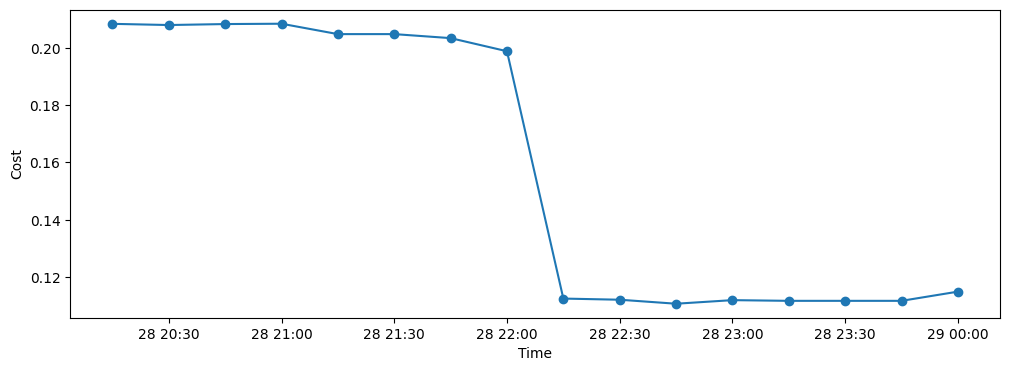

In [28]:
# Plot the forecast total costs within the window of the lowest cost
plt.figure(figsize=(12, 4))
plt.plot(df_scrooge_new[(df_scrooge_new['timestamp'] > '2018-12-28 20:00:00') & (df_scrooge_new['timestamp'] <= '2018-12-29 00:00:00')].timestamp,
         df_scrooge_new[(df_scrooge_new['timestamp'] > '2018-12-28 20:00:00') & (df_scrooge_new['timestamp'] <= '2018-12-29 00:00:00')].cost, marker='o')
_ = plt.xlabel('Time')
_ = plt.ylabel('Cost')

### The finishing touches to the forecasts

With such limited amount of data samples available, it is (almost) impossible to give perfect forecasts of future energy consumption.

In the following section, we observe the general trends of recent load profiles and compare them with what we have predicted so far.

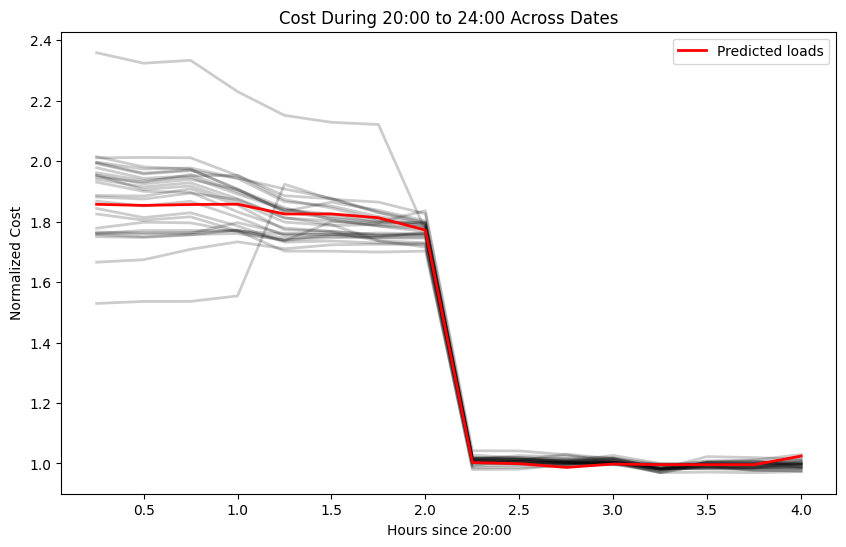

In [29]:
# Create the dataframe of the historical data
start_date = '2018-11-26 00:15:00'
end_date = '2018-12-22 00:15:00'
df_scrooge_new_sub = df_scrooge_new[(df_scrooge_new['timestamp'] >= start_date) & (df_scrooge_new['timestamp'] < end_date)] \
                     [['timestamp', 'cost']].reset_index(drop=True)
start_date = pd.to_datetime(start_date)
end_date = pd.to_datetime(end_date)

# Create a matplotlib figure
plt.figure(figsize=(10, 6)) 

# Iterate over the dates
current_date = start_date
while current_date < end_date:
    next_date = current_date + pd.DateOffset(days=1)

    # Filter the data of the specific date
    mask = (df_scrooge_new_sub['timestamp'] > current_date.strftime('%Y-%m-%d 20:00:00')) & \
           (df_scrooge_new_sub['timestamp'] <= next_date.strftime('%Y-%m-%d 00:00:00'))
    filtered_data = df_scrooge_new_sub.loc[mask].copy()
        
    # Transform the time column into "hour since 20:00" format
    filtered_data['time_since_20'] = (filtered_data['timestamp'] - 
                                      pd.to_datetime(current_date.strftime('%Y-%m-%d 20:00:00'))).dt.total_seconds() / 3600.0

    # Plot the costs of the specific date normalized by the mean cost of the last 2 hours in the window
    denominator = filtered_data['cost'].iloc[-8:].mean()
    plt.plot(filtered_data['time_since_20'], filtered_data['cost'] / denominator, color='k', alpha=0.2, linewidth=2)

    # Update the date
    current_date = next_date

# Plot the predicted loads
current_date = pd.to_datetime('2018-12-28')
filtered_data = df_scrooge_new[(df_scrooge_new['timestamp'] > '2018-12-28 20:00:00') & (df_scrooge_new['timestamp'] <= '2018-12-29 00:00:00')].copy()
filtered_data['time_since_20'] = (filtered_data['timestamp'] - pd.to_datetime(current_date.strftime('%Y-%m-%d 20:00:00'))).dt.total_seconds() / 3600.0
denominator = filtered_data['cost'].iloc[-8:].mean()
plt.plot(filtered_data['time_since_20'], filtered_data['cost'] / denominator, color='r', linewidth=2, label='Predicted loads')

# Add labels and titles
plt.xlabel('Hours since 20:00')
plt.ylabel('Normalized Cost')
plt.title('Cost During 20:00 to 24:00 Across Dates')
plt.legend()
plt.show()

As is seen in the figure above, the (normalized) predicted values are pretty close to the median values of recent load profiles. The question now is we have no information about what exactly happened during 20:00:00 and 24:00:00 in 2018-12-28. If we look at the temperature (an average of over 14 degrees Celcius), we might as well guess that the heating and heating_hp_bkup loads can be reasonably low (when compared with historical load profiles). However, as 2018-12-28 is the first Friday after Christmas, the need for heating may increase.

As a practical strategy for the competition, we tried to modify the predicted loads without changing the total cost. What we arrived at eventually is the modification scenario calculated as follows:

In [30]:
# Make a copy of the original predictied loads
filtered_data_prior_to_modification = filtered_data['cost'] / denominator

# Modify the loads
df_scrooge_new.loc[df_scrooge_new.timestamp == '2018-12-28 20:15:00', 'cost'] = \
df_scrooge_new.loc[df_scrooge_new.timestamp == '2018-12-28 20:15:00', 'cost'] + 0.031125
df_scrooge_new.loc[df_scrooge_new.timestamp == '2018-12-28 20:30:00', 'cost'] = \
df_scrooge_new.loc[df_scrooge_new.timestamp == '2018-12-28 20:30:00', 'cost'] + 0.014625
df_scrooge_new.loc[df_scrooge_new.timestamp == '2018-12-28 20:45:00', 'cost'] = \
df_scrooge_new.loc[df_scrooge_new.timestamp == '2018-12-28 20:45:00', 'cost'] - 0.003875
df_scrooge_new.loc[df_scrooge_new.timestamp == '2018-12-28 21:00:00', 'cost'] = \
df_scrooge_new.loc[df_scrooge_new.timestamp == '2018-12-28 21:00:00', 'cost'] - 0.005375
df_scrooge_new.loc[df_scrooge_new.timestamp == '2018-12-28 21:15:00', 'cost'] = \
df_scrooge_new.loc[df_scrooge_new.timestamp == '2018-12-28 21:15:00', 'cost'] - 0.010375
df_scrooge_new.loc[df_scrooge_new.timestamp == '2018-12-28 21:30:00', 'cost'] = \
df_scrooge_new.loc[df_scrooge_new.timestamp == '2018-12-28 21:30:00', 'cost'] - 0.007375
df_scrooge_new.loc[df_scrooge_new.timestamp == '2018-12-28 21:45:00', 'cost'] = \
df_scrooge_new.loc[df_scrooge_new.timestamp == '2018-12-28 21:45:00', 'cost'] - 0.009875
df_scrooge_new.loc[df_scrooge_new.timestamp == '2018-12-28 22:00:00', 'cost'] = \
df_scrooge_new.loc[df_scrooge_new.timestamp == '2018-12-28 22:00:00', 'cost'] - 0.008875

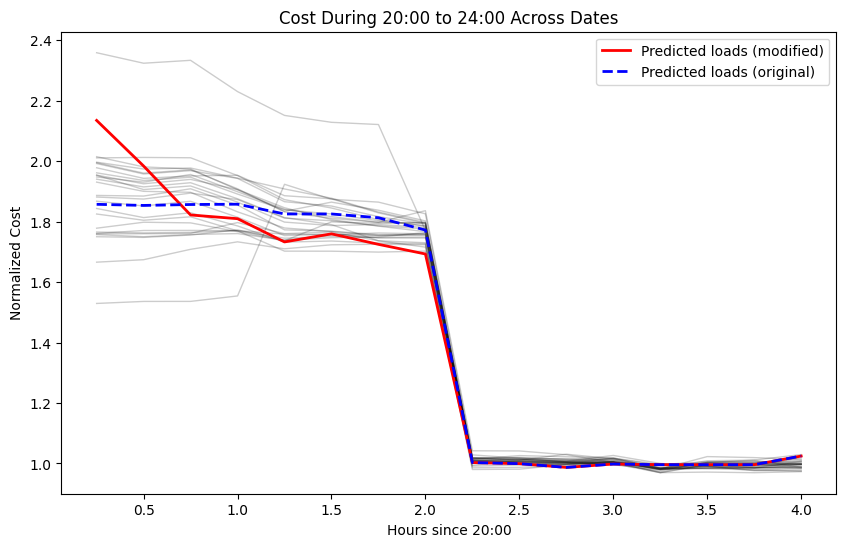

In [31]:
# Create the dataframe of the historical data
start_date = '2018-11-26 00:15:00'
end_date = '2018-12-22 00:15:00'
df_scrooge_new_sub = df_scrooge_new[(df_scrooge_new['timestamp'] >= start_date) & (df_scrooge_new['timestamp'] < end_date)] \
                     [['timestamp', 'cost']].reset_index(drop=True)
start_date = pd.to_datetime(start_date)
end_date = pd.to_datetime(end_date)

# Create a matplotlib figure
plt.figure(figsize=(10, 6)) 

# Iterate over the dates
current_date = start_date
while current_date < end_date:
    next_date = current_date + pd.DateOffset(days=1)

    # Filter the data of the specific date
    mask = (df_scrooge_new_sub['timestamp'] > current_date.strftime('%Y-%m-%d 20:00:00')) & \
           (df_scrooge_new_sub['timestamp'] <= next_date.strftime('%Y-%m-%d 00:00:00'))
    filtered_data = df_scrooge_new_sub.loc[mask].copy()
        
    # Transform the time column into "hour since 20:00" format
    filtered_data['time_since_20'] = (filtered_data['timestamp'] - 
                                      pd.to_datetime(current_date.strftime('%Y-%m-%d 20:00:00'))).dt.total_seconds() / 3600.0

    # Plot the costs of the specific date normalized by the mean cost of the last 2 hours in the window
    denominator = filtered_data['cost'].iloc[-8:].mean()
    plt.plot(filtered_data['time_since_20'], filtered_data['cost'] / denominator, color='k', alpha=0.2, linewidth=1)

    # Update the date
    current_date = next_date

# Plot the predicted loads
current_date = pd.to_datetime('2018-12-28')
filtered_data = df_scrooge_new[(df_scrooge_new['timestamp'] > '2018-12-28 20:00:00') & (df_scrooge_new['timestamp'] <= '2018-12-29 00:00:00')].copy()
filtered_data['time_since_20'] = (filtered_data['timestamp'] - pd.to_datetime(current_date.strftime('%Y-%m-%d 20:00:00'))).dt.total_seconds() / 3600.0
denominator = filtered_data['cost'].iloc[-8:].mean()
plt.plot(filtered_data['time_since_20'], filtered_data['cost'] / denominator, color='r', linewidth=2, label='Predicted loads (modified)')
plt.plot(filtered_data['time_since_20'], filtered_data_prior_to_modification, color='b', linewidth=2, linestyle='--', label='Predicted loads (original)')

# Add labels and titles
plt.xlabel('Hours since 20:00')
plt.ylabel('Normalized Cost')
plt.title('Cost During 20:00 to 24:00 Across Dates')
plt.legend()
plt.show()

The modificatin basically raises the loads of the first two time intervals and lowers the loads afterwards. The loads of the last 8 intervals are not modified.

In [32]:
# Calculate the total cost
print('Total cost is:', df_scrooge_new[(df_scrooge_new['timestamp'] > '2018-12-28 20:00:00') &
      (df_scrooge_new['timestamp'] <= '2018-12-29 00:00:00')].cost.sum())

Total cost is: 2.5421991914023963


### Submission File Generation

Your submission file should be in `.csv` format consisting of two columns called `timestamp` and `party_cost` with 16 rows corresponding to 4-hour optimal Party time. For instance, if you decide that the optimal time for the Party is `Dec 25, 2018, 5:00-9:00 pm`, the `timestamp` column of your submitted csv file should start with `2018-12-25 17:15:00` and end with `2018-12-25 21:00:00` with a total of 16 rows. The values in the `party_cost` column should be in dollars. Minutes (`%M`) in the datetime format `%Y-%m-%d %H:%M:%S` must only take one of the values `00`, `15`, `30`, or `45`, while the Seconds (`%S`) must always be set to `00`. Additionally, ensure that the rows are arranged in chronological order with 15-minute increments.

In [33]:
# Generate the submission file
df_sample = df_scrooge_new[(df_scrooge_new.timestamp > '2018-12-28 20:00:00') & (df_scrooge_new.timestamp <= '2018-12-29 00:00:00')] \
            [['timestamp', 'cost']].reset_index(drop=True)
df_sample = df_sample.rename({'cost': 'party_cost'}, axis=1)

# The total party cost should be 2.542199 is the notebook is properly run
print(f'The total party cost is: {df_sample.party_cost.sum():.6f}')

The total party cost is: 2.542199


In [34]:
df_sample.to_csv('submission_caracara.csv', index = False)